In [117]:
import pandas as pd
import numpy as np
from keras import Model, Sequential
from keras.applications import VGG16, VGG19
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from keras import backend as K
from keras.layers import *
import keras
K.set_image_data_format('channels_last')

path = '../Data/'

class_emb = pd.read_csv(path + '/DatasetA_train_20180813/class_wordembeddings.txt', 
                        index_col = 0, sep = ' ', header = None)
class_emb.index.name = 'class_name'
# class_emb_vec = pd.DataFrame(index = class_emb.index)
class_emb = class_emb.apply(lambda s: np.array([float(x) for x in s]), axis = 1)

class_id_to_name = pd.read_csv(path + '/DatasetA_train_20180813/label_list.txt', 
                               index_col = 'class_name', sep = '\t', header = None, names = ['class_id', 'class_name'])

attr_list = pd.read_csv(path + '/DatasetA_train_20180813/attribute_list.txt', index_col = 0, sep = '\t', header = None)

attributes_per_class = pd.read_csv(path + '/DatasetA_train_20180813/attributes_per_class.txt', 
                                   index_col = 0, sep = '\t', header = None)
attributes_per_class.index.name = 'class_id'
attributes_per_class = attributes_per_class.apply(lambda s: np.array([float(x) for x in s]), axis = 1)

train_data = pd.read_csv(path + '/DatasetA_train_20180813/train.txt', index_col = 'class_id', 
                         sep = '\t', header = None, names = ['image_id', 'class_id'])

class_id_emb_attr = class_id_to_name.copy()
class_id_emb_attr['emb'] = class_emb
class_id_emb_attr.reset_index(inplace = True)
class_id_emb_attr.set_index('class_id', inplace = True)
class_id_emb_attr['attr'] = attributes_per_class
train_data = train_data.merge(class_id_emb, how = 'left', on = 'class_id')

In [118]:
imag_path = path + r'/DatasetA_train_20180813/train/'
def read_image(image_id):
    img = image.load_img(imag_path + image_id)
    img= image.img_to_array(img) / 255
    return img
train_data['img'] = train_data['image_id'].apply(lambda id: read_image(id))

train_data.reset_index(inplace = True)

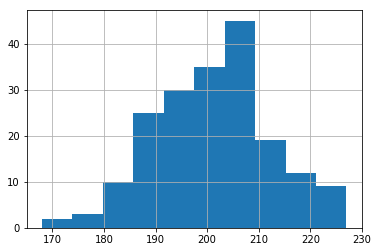

In [173]:
# np.asarray(list(train_data['img'])).shape
# train_data[train_data['class_id'] == 'ZJL1']
train_data['class_id'].value_counts().hist()

In [130]:
#build model
from keras import Model, Sequential
from keras.applications import VGG16, VGG19
from keras.layers import Flatten, Dense
from keras.preprocessing import image
from sklearn.model_selection import train_test_split
from keras import backend as K
K.set_image_data_format('channels_last')


vgg_model = VGG16(include_top=False, weights='imagenet', input_shape=(64, 64, 3))
 
# classes = {
#     'cla' : 6+1,
#   #  'clo' : 8, #暂且不用
#     'has' : 4,
#     'for' : 6
#   #  'is' : 6 #暂且不用
# }
 
# x = base_model.output
# x = Flatten()(x)
# x = Dense(1024, activation='relu')(x)
# # predictions = [Dense(n, activation='softmax', name=m)(x) for m,n in classes.items()]
# predictions = [Dense(1, activation='sigmoid', name=m.replace(' ', '_'))(x) for m in head[1:]]
 
# model = Model(inputs=base_model.input, outputs= predictions)
# model.compile(optimizer='rmsprop', loss='binary_crossentropy')
# model.summary()

vgg_model.summary()

In [134]:
class RmseEvaluation(Callback):
    def __init__(self, validation_data=(), interval=1, batch_interval = 1000000, verbose = 2, \
            scores = []):
        super(Callback, self).__init__()

        self.interval = interval
        self.X_val, self.y_val = validation_data
        # print("y_val shape:{0}".format(self.y_val.shape))
        self.batch_interval = batch_interval
        self.verbose = verbose
        self.scores = scores

    def on_epoch_end(self, epoch, logs={}):
        if epoch % self.interval == 0:
            y_pred = self.model.predict(self.X_val, verbose=0, batch_size=10240)
            score = np.sqrt(metrics.mean_squared_error(self.y_val, y_pred))
            self.scores.append("epoch:{0} {1}".format(epoch + 1, score))
            print("\n RMSE - epoch: %d - score: %.6f \n" % (epoch+1, score))
    
    def on_batch_end(self, batch, logs={}):
        return
        if(self.verbose >= 2) and (batch % self.batch_interval == 0):
            # y_pred = self.model.predict(self.X_val, verbose=0)
            # loss = metrics.log_loss(self.y_val, y_pred)
            print("Hi! on_batch_end() , batch=",batch,",logs:",logs)
            # print("Valide size=",y_pred.shape[0], "  Valide loss=",loss)

attr_input = Input(shape = (30,))
word_emb = Input(shape = (300,))
imag_classifier = Input(shape = (1024,))

# attr_dense = Dense(2048, activation="relu")(attr_input)
# attr_dense = Dense(2048, activation="relu")(attr_input)
attr_dense = Dense(1024, activation="relu")(attr_input)
# attr_dense = Dense(512, activation="relu")(attr_dense)

attr_word_emb = Concatenate()([word_emb, attr_dense])

attr_word_emb_dense = Dense(2048, activation="relu")(attr_word_emb)
attr_word_emb_dense = Dropout(0.2)(attr_word_emb_dense)
# attr_word_emb_dense = Dense(2048, activation="relu")(attr_word_emb_dense)
attr_word_emb_dense = Dense(1024, activation="relu")(attr_word_emb_dense)
attr_word_emb_dense = Dropout(0.2)(attr_word_emb_dense)
attr_word_emb_dense = Dense(512, activation="relu")(attr_word_emb_dense)
attr_word_emb_dense = Dropout(0.2)(attr_word_emb_dense)
# attr_word_emb_dense = Dense(2048, activation="sigmoid", kernel_regularizer=keras.regularizers.l2(0.01))(attr_word_emb_dense)
attr_word_emb_dense = Dense(2048, activation="relu")(attr_word_emb_dense)

# mse = Dense(6, activation="softmax")(dense_output)
vgg_input = vgg_model.input
vgg_output = Flatten()(vgg_model.output)
vgg_output = Dense(1024, activation="sigmoid")(vgg_output)

# mse_loss = keras.losses.mean_squared_error(vgg_output, attr_word_emb_dense)

model = Model([attr_input, word_emb], outputs = attr_word_emb_dense) #, vgg_output])
# model.add_loss(mse_loss)
model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_5 (InputLayer)            (None, 30)           0                                            
__________________________________________________________________________________________________
input_6 (InputLayer)            (None, 300)          0                                            
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 1024)         31744       input_5[0][0]                    
__________________________________________________________________________________________________
concatenate_2 (Concatenate)     (None, 1324)         0           input_6[0][0]                    
                                                                 dense_7[0][0]                    
__________

In [174]:
train_data_part = train_data #[:1000]
train_data_part_length = train_data_part.shape[0]
print ('Train length: ', train_data_part.shape[0])

train_data_part_img = np.asarray(list(train_data_part['img']))
train_y = np.reshape(vgg_model.predict(train_data_part_img, verbose=  1), (train_data_part_length, -1)) #data.loc[class_id] #data_atten.loc[n]
    
h = model.fit([np.asarray(list(train_data_part['attr'])), np.asarray(list(train_data_part['emb']))], train_y, 
              epochs=100,validation_split=0.2, batch_size = 64, shuffle=True, verbose = 1)

Train length:  38221
38221/38221 [==============================] - 2415s 63ms/step
Train on 30576 samples, validate on 7645 samples
Epoch 1/100
30576/30576 [==============================] - 18s 584us/step - loss: 0.0876 - val_loss: 0.0990
Epoch 2/100
30576/30576 [==============================] - 18s 575us/step - loss: 0.0836 - val_loss: 0.0963
Epoch 3/100
30576/30576 [==============================] - 17s 570us/step - loss: 0.0821 - val_loss: 0.0933
Epoch 4/100
30576/30576 [==============================] - 17s 569us/step - loss: 0.0811 - val_loss: 0.0917
Epoch 5/100
30576/30576 [==============================] - 22s 711us/step - loss: 0.0804 - val_loss: 0.0917
Epoch 6/100
30576/30576 [==============================] - 19s 606us/step - loss: 0.0801 - val_loss: 0.0915
Epoch 7/100
30576/30576 [==============================] - 18s 588us/step - loss: 0.0798 - val_loss: 0.0924
Epoch 8/100
30576/30576 [==============================] - 18s 582us/step - loss: 0.0795 - val_loss: 0.0929
Epo

30576/30576 [==============================] - 17s 570us/step - loss: 0.0751 - val_loss: 0.0944
Epoch 76/100
30576/30576 [==============================] - 17s 570us/step - loss: 0.0751 - val_loss: 0.0940
Epoch 77/100
30576/30576 [==============================] - 17s 570us/step - loss: 0.0750 - val_loss: 0.0949
Epoch 78/100
30576/30576 [==============================] - 17s 571us/step - loss: 0.0750 - val_loss: 0.0953
Epoch 79/100
30576/30576 [==============================] - 18s 578us/step - loss: 0.0750 - val_loss: 0.0942
Epoch 80/100
30576/30576 [==============================] - 18s 573us/step - loss: 0.0749 - val_loss: 0.0945
Epoch 81/100
30576/30576 [==============================] - 18s 578us/step - loss: 0.0749 - val_loss: 0.0943
Epoch 82/100
30576/30576 [==============================] - 18s 574us/step - loss: 0.0749 - val_loss: 0.0939
Epoch 83/100
30576/30576 [==============================] - 18s 590us/step - loss: 0.0749 - val_loss: 0.0953
Epoch 84/100
30576/30576 [======

In [177]:
import pickle

with open(path + 'train_vgg16_img_div255.pickle', 'wb+') as handle:
    pickle.dump(train_y, handle)
# with open(path + 'train_vgg16.pickle', 'rb') as handle:
#     train_y = pickle.load(handle)

In [ ]:
 
data_test = open("D:\\data\\pic\\DatasetA_test_20180813\\DatasetA_test\\image.txt")
data_test = data_test.readlines()
path_test = r'D:\data\pic\DatasetA_test_20180813\DatasetA_test\test\\'
length = len(data_test)
data_test_x = np.zeros((length, 64, 64, 3))
for i in range(length):
    m = data_test[i][:-1]
    img = image.load_img(path_test + m)
    data_test_x[i] = image.img_to_array(img)
 
res = model.predict(data_test_x)
 
#欧氏距离：
data_atten_res = []
for i in range(160,241):
    key = 'ZJL' + str(i)
    data_atten_res.append(np.hstack((data_atten.loc[key][1:8], data_atten.loc[key][16:20], data_atten.loc[key][20:26])))
 
vec_result = []#np.zores((len(res[0]), 18))
for i in range(len(res[0])):
    vec_result.append(np.hstack((res[0][i], res[1][i], res[2][i])))
dis_list = []
 
for j in range(len(data_atten_res)):
    vec1 = vec_result[0]
    vec2 = data_atten_res[j]
    dist = np.linalg.norm(vec1 - vec2)
    dis_list.append(dist)
print("witch is : "+ str(dis_list.index(min(dis_list))) + " and min dis = " + str(min(dis_list)))